# ISP-GIN vs RealGIN-Aug vs GIN: Graph Classification on MUTAG

This notebook demonstrates a **pure PyTorch** (no PyG dependency) implementation of 3 Graph Neural Network models for graph classification:

1. **GIN Baseline** — Standard Graph Isomorphism Network
2. **RealGIN-Aug** — GIN with 5 concatenated topological node features (degree, clustering, neighbor stats, random walk)
3. **ISP-GIN** — Complex-valued GIN with K frequency channels using interference-based structural probing

All models are trained and evaluated on the **MUTAG** dataset (mutagenicity classification of aromatic compounds) using stratified k-fold cross-validation.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'matplotlib==3.10.0', 'networkx==3.6.1', 'scipy==1.16.3')
    _pip('torch==2.9.0', '--index-url', 'https://download.pytorch.org/whl/cpu')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import time
import math
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import Optional
import matplotlib.pyplot as plt

## Data Loading

Load the mini MUTAG dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-1a90b0-interference-based-structural-probing-br/main/experiment_iter4_isp_gin_vs_real/demo/mini_demo_data.json"
import os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} graphs")

Loaded 1 dataset(s)
  MUTAG: 50 graphs


## Configuration

All tunable hyperparameters. Adjust these to trade off between speed and accuracy.

In [5]:
# ── Hyperparameters ──
# These match the original full experiment values.
# With the 50-graph MUTAG demo subset, training completes in ~30s.

HIDDEN_DIM = 64        # Original: 64
NUM_LAYERS = 3         # Original: 3
DROPOUT = 0.5          # Original: 0.5
LR = 0.01              # Original: 0.01
MAX_EPOCHS = 100       # Original: 100
PATIENCE = 20          # Original: 20
BATCH_SIZE = 32        # Original: 32
ISP_K = 4              # Original: 4
NUM_FOLDS = 10         # Original: 10 (uses all available folds)
SEED = 42

DATASET_FEATURE_DIMS = {"MUTAG": 7}

torch.set_num_threads(1)
torch.manual_seed(SEED)
np.random.seed(SEED)

## Graph Data Structures & Conversion

Minimal graph data container (replaces PyG `Data`) and conversion from JSON to tensors.

In [6]:
class GraphData:
    """Minimal graph data container (replaces PyG Data)."""

    def __init__(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        y: torch.Tensor,
        num_nodes: int,
        graph_id: int = 0,
        fold: int = 0,
        rw_t3: Optional[torch.Tensor] = None,
        topo_features: Optional[torch.Tensor] = None,
    ):
        self.x = x
        self.edge_index = edge_index
        self.y = y
        self.num_nodes = num_nodes
        self.graph_id = graph_id
        self.fold = fold
        self.rw_t3 = rw_t3
        self.topo_features = topo_features


def example_to_graph(example: dict, dataset_name: str, feature_dim: int) -> GraphData:
    """Convert a single JSON example to a GraphData object."""
    graph_json = json.loads(example["input"])
    edge_list = graph_json["edge_list"]
    node_features = graph_json["node_features"]
    num_nodes = graph_json["num_nodes"]

    # Build undirected edge_index
    if edge_list:
        src = [e[0] for e in edge_list]
        dst = [e[1] for e in edge_list]
        all_src = src + dst
        all_dst = dst + src
        edge_index = torch.tensor([all_src, all_dst], dtype=torch.long)
    else:
        edge_index = torch.zeros((2, 0), dtype=torch.long)

    x = torch.tensor(node_features, dtype=torch.float)

    if dataset_name == "IMDB-BINARY" and feature_dim == 1:
        max_val = x.max().item()
        if max_val > 0:
            x = x / max_val

    y = torch.tensor(int(example["output"]), dtype=torch.long)
    fold = example.get("metadata_fold", 0)
    graph_id = example.get("metadata_graph_id", 0)

    return GraphData(
        x=x,
        edge_index=edge_index,
        y=y,
        num_nodes=num_nodes,
        graph_id=graph_id,
        fold=fold,
    )


def convert_dataset(examples: list, dataset_name: str, feature_dim: int) -> list:
    """Convert all examples of a dataset to GraphData objects."""
    return [example_to_graph(ex, dataset_name, feature_dim) for ex in examples]


# Convert loaded data
ds_entry = data['datasets'][0]  # MUTAG
ds_name = ds_entry['dataset']
feat_dim = DATASET_FEATURE_DIMS[ds_name]
examples = ds_entry['examples']
graphs = convert_dataset(examples, ds_name, feat_dim)
print(f"Converted {ds_name}: {len(graphs)} graphs, feat_dim={feat_dim}")

Converted MUTAG: 50 graphs, feat_dim=7


## Topological Feature Computation (for RealGIN-Aug)

Compute 5 topological features per node: normalized degree, local clustering coefficient, neighbor degree mean/variance, and random walk return probability (t=3).

In [7]:
def compute_topo_features(edge_list: list, num_nodes: int) -> torch.Tensor:
    """Compute 5 topological features per node.

    Returns (num_nodes, 5) tensor:
      0: normalized degree
      1: local clustering coefficient
      2: neighbor degree mean (normalized)
      3: neighbor degree variance (normalized)
      4: random walk return probability (t=3)
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edge_list)

    features = np.zeros((num_nodes, 5), dtype=np.float32)

    degrees = np.array([G.degree(v) for v in range(num_nodes)], dtype=np.float64)
    max_deg = max(degrees.max(), 1.0)
    features[:, 0] = degrees / max_deg

    cc = nx.clustering(G)
    for v in range(num_nodes):
        features[v, 1] = cc.get(v, 0.0)

    for v in range(num_nodes):
        nbrs = list(G.neighbors(v))
        if nbrs:
            features[v, 2] = np.mean([G.degree(u) for u in nbrs]) / max_deg

    for v in range(num_nodes):
        nbrs = list(G.neighbors(v))
        if nbrs:
            features[v, 3] = np.var([G.degree(u) for u in nbrs]) / (max_deg ** 2)

    if num_nodes <= 200:
        A = nx.adjacency_matrix(G).toarray().astype(np.float64)
        deg_safe = np.maximum(degrees, 1.0)
        D_inv = np.diag(1.0 / deg_safe)
        P = D_inv @ A
        P3 = np.linalg.matrix_power(P, 3)
        rw_diag = np.diag(P3).astype(np.float32)
    else:
        from scipy.sparse import diags as sp_diags
        A_sp = nx.adjacency_matrix(G).astype(np.float64)
        deg_safe = np.maximum(degrees, 1.0)
        D_inv_sp = sp_diags(1.0 / deg_safe)
        P_sp = D_inv_sp @ A_sp
        rw_diag = np.zeros(num_nodes, dtype=np.float32)
        for v in range(num_nodes):
            e_v = np.zeros(num_nodes, dtype=np.float64)
            e_v[v] = 1.0
            p = e_v
            for _ in range(3):
                p = P_sp.T @ p
            rw_diag[v] = p[v]

    features[:, 4] = np.clip(rw_diag, 0.0, 1.0)
    return torch.tensor(features, dtype=torch.float)


def precompute_topo_for_graphs(graphs: list, examples: list) -> None:
    """Precompute and attach topological features and rw_t3 to each graph."""
    for g, ex in zip(graphs, examples):
        graph_json = json.loads(ex["input"])
        edge_list = graph_json["edge_list"]
        num_nodes = graph_json["num_nodes"]
        topo = compute_topo_features(edge_list, num_nodes)
        g.topo_features = topo
        g.rw_t3 = topo[:, 4].clone()


t0 = time.time()
precompute_topo_for_graphs(graphs, examples)
print(f"Topological features computed for {len(graphs)} graphs in {time.time()-t0:.1f}s")

Topological features computed for 50 graphs in 0.2s


## Batching Utilities & Pooling

Custom batching (replaces PyG DataLoader) — combines multiple graphs into a single disconnected graph with batch assignment tensor.

In [8]:
class Batch:
    """Batched graph data, combining multiple graphs into a single disconnected graph."""

    def __init__(self, x, edge_index, y, batch, rw_t3=None, topo_features=None):
        self.x = x
        self.edge_index = edge_index
        self.y = y
        self.batch = batch
        self.rw_t3 = rw_t3
        self.topo_features = topo_features
        self.num_graphs = y.size(0)


def collate_graphs(graph_list: list) -> Batch:
    """Collate a list of GraphData into a single Batch."""
    xs, eis, ys, batches = [], [], [], []
    rw_t3s, topos = [], []
    node_offset = 0
    for i, g in enumerate(graph_list):
        xs.append(g.x)
        if g.edge_index.size(1) > 0:
            eis.append(g.edge_index + node_offset)
        else:
            eis.append(g.edge_index)
        ys.append(g.y.unsqueeze(0))
        batches.append(torch.full((g.num_nodes,), i, dtype=torch.long))
        if g.rw_t3 is not None:
            rw_t3s.append(g.rw_t3)
        if g.topo_features is not None:
            topos.append(g.topo_features)
        node_offset += g.num_nodes

    x = torch.cat(xs, dim=0)
    edge_index = torch.cat(eis, dim=1) if eis else torch.zeros((2, 0), dtype=torch.long)
    y = torch.cat(ys, dim=0)
    batch = torch.cat(batches, dim=0)
    rw_t3 = torch.cat(rw_t3s, dim=0) if rw_t3s else None
    topo = torch.cat(topos, dim=0) if topos else None

    return Batch(x=x, edge_index=edge_index, y=y, batch=batch, rw_t3=rw_t3, topo_features=topo)


def make_batches(graphs: list, batch_size: int, shuffle: bool = False) -> list:
    """Create batches from a list of graphs."""
    indices = list(range(len(graphs)))
    if shuffle:
        np.random.shuffle(indices)
    batches = []
    for start in range(0, len(indices), batch_size):
        batch_idx = indices[start:start + batch_size]
        batch_graphs = [graphs[i] for i in batch_idx]
        batches.append(collate_graphs(batch_graphs))
    return batches


def global_add_pool(x: torch.Tensor, batch: torch.Tensor, num_graphs: int) -> torch.Tensor:
    """Sum pooling: aggregate node features to graph level."""
    out = torch.zeros(num_graphs, x.size(1), dtype=x.dtype, device=x.device)
    out.scatter_add_(0, batch.unsqueeze(1).expand_as(x), x)
    return out

print("Batching utilities defined.")

Batching utilities defined.


## Model Definitions

Three GNN architectures:
- **GINConvLayer / GINBaseline**: Standard GIN with learnable epsilon
- **RealGINAug**: GIN with concatenated topological features (5 extra dims)
- **ComplexGINConvLayer / ISPGIN**: Complex-valued GIN with K frequency channels

In [9]:
class GINConvLayer(nn.Module):
    """Single GIN Convolution layer: MLP((1+eps)*x_v + SUM(x_u for u in N(v)))"""

    def __init__(self, in_dim: int, out_dim: int, train_eps: bool = True):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim),
        )
        if train_eps:
            self.eps = nn.Parameter(torch.zeros(1))
        else:
            self.register_buffer("eps", torch.zeros(1))

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        N = x.size(0)
        row, col = edge_index
        agg = torch.zeros(N, x.size(1), dtype=x.dtype, device=x.device)
        agg.scatter_add_(0, col.unsqueeze(1).expand(col.size(0), x.size(1)), x[row])
        out = (1.0 + self.eps) * x + agg
        return self.mlp(out)


class GINBaseline(nn.Module):
    """Standard Graph Isomorphism Network for graph classification."""

    def __init__(self, input_dim, hidden_dim=64, num_layers=3, num_classes=2, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(num_layers):
            in_d = input_dim if i == 0 else hidden_dim
            self.convs.append(GINConvLayer(in_d, hidden_dim, train_eps=True))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hidden_dim, num_classes),
        )
        self.num_layers = num_layers

    def forward(self, batch: Batch) -> torch.Tensor:
        x = batch.x
        edge_index = batch.edge_index
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
        x = global_add_pool(x, batch.batch, batch.num_graphs)
        return self.classifier(x)


class RealGINAug(GINBaseline):
    """GIN with augmented input = original_features || topo_features (5 extra dims)."""

    def forward(self, batch: Batch) -> torch.Tensor:
        x = torch.cat([batch.x, batch.topo_features], dim=-1)
        edge_index = batch.edge_index
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
        x = global_add_pool(x, batch.batch, batch.num_graphs)
        return self.classifier(x)


class ComplexGINConvLayer(nn.Module):
    """GIN convolution for split real/imaginary representation."""

    def __init__(self, in_dim: int, out_dim: int, train_eps: bool = True):
        super().__init__()
        self.lin1_real = nn.Linear(in_dim, out_dim)
        self.lin2_real = nn.Linear(out_dim, out_dim)
        self.lin1_imag = nn.Linear(in_dim, out_dim)
        self.lin2_imag = nn.Linear(out_dim, out_dim)
        if train_eps:
            self.eps = nn.Parameter(torch.zeros(1))
        else:
            self.register_buffer("eps", torch.zeros(1))

    def forward(self, x_real, x_imag, edge_index):
        N = x_real.size(0)
        row, col = edge_index
        agg_real = torch.zeros(N, x_real.size(1), dtype=x_real.dtype)
        agg_imag = torch.zeros(N, x_imag.size(1), dtype=x_imag.dtype)
        if edge_index.size(1) > 0:
            agg_real.scatter_add_(0, col.unsqueeze(1).expand(col.size(0), x_real.size(1)), x_real[row])
            agg_imag.scatter_add_(0, col.unsqueeze(1).expand(col.size(0), x_imag.size(1)), x_imag[row])
        out_real = (1.0 + self.eps) * x_real + agg_real
        out_imag = (1.0 + self.eps) * x_imag + agg_imag
        out_real = F.relu(self.lin1_real(out_real))
        out_real = self.lin2_real(out_real)
        out_imag = F.relu(self.lin1_imag(out_imag))
        out_imag = self.lin2_imag(out_imag)
        return out_real, out_imag


class ISPGIN(nn.Module):
    """Complex-valued GIN with K frequency channels.

    Phase initialization: z_v = exp(i * omega_k * rw_t3(v))
    After message passing, extract magnitude and concatenate across K channels.
    """

    def __init__(self, K=8, hidden_dim=64, num_layers=3, num_classes=2, dropout=0.5):
        super().__init__()
        self.K = K
        self.num_layers = num_layers
        omegas = [2.0 * math.pi * k / K for k in range(K)]
        self.register_buffer("omegas", torch.tensor(omegas, dtype=torch.float))
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            in_d = 1 if i == 0 else hidden_dim
            self.convs.append(ComplexGINConvLayer(in_d, hidden_dim, train_eps=True))
        self.classifier = nn.Sequential(
            nn.Linear(K * hidden_dim, hidden_dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, batch: Batch) -> torch.Tensor:
        edge_index = batch.edge_index
        rw_t3 = batch.rw_t3
        all_mags = []
        for k in range(self.K):
            omega = self.omegas[k].item()
            phase = omega * rw_t3
            z_real = torch.cos(phase).unsqueeze(-1)
            z_imag = torch.sin(phase).unsqueeze(-1)
            for conv in self.convs:
                z_real, z_imag = conv(z_real, z_imag, edge_index)
            mag = torch.sqrt(z_real ** 2 + z_imag ** 2 + 1e-8)
            all_mags.append(mag)
        x = torch.cat(all_mags, dim=-1)
        x = global_add_pool(x, batch.batch, batch.num_graphs)
        return self.classifier(x)

print("Models defined: GINBaseline, RealGINAug, ISPGIN")

Models defined: GINBaseline, RealGINAug, ISPGIN


## Training & Evaluation

Train one epoch, evaluate accuracy, and run k-fold cross-validation for all three models.

In [10]:
def train_one_epoch(model, batches, optimizer):
    """Train for one epoch, return average loss."""
    model.train()
    total_loss = 0.0
    total_graphs = 0
    for batch in batches:
        optimizer.zero_grad()
        out = model(batch)
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    return total_loss / max(total_graphs, 1)


@torch.no_grad()
def evaluate(model, batches):
    """Evaluate model, return (accuracy, list_of_predictions)."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    for batch in batches:
        out = model(batch)
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += batch.num_graphs
        all_preds.extend(pred.tolist())
    return correct / max(total, 1), all_preds


def train_and_evaluate_fold(model_class, model_kwargs, train_graphs, test_graphs,
                            max_epochs=MAX_EPOCHS, patience=PATIENCE, lr=LR,
                            batch_size=BATCH_SIZE):
    """Train a model on one fold. Returns (best_test_acc, best_predictions, best_epoch)."""
    model = model_class(**model_kwargs)
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, patience=10, factor=0.5, mode="min")

    best_test_acc = 0.0
    best_preds = []
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        train_batches = make_batches(train_graphs, batch_size=batch_size, shuffle=True)
        avg_loss = train_one_epoch(model, train_batches, optimizer)
        test_batches = make_batches(test_graphs, batch_size=batch_size, shuffle=False)
        test_acc, test_preds = evaluate(model, test_batches)
        scheduler.step(avg_loss)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_preds = test_preds
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

    return best_test_acc, best_preds, best_epoch


def run_kfold_cv(model_class, model_kwargs, graphs, method_name, num_folds=NUM_FOLDS,
                 max_epochs=MAX_EPOCHS, patience=PATIENCE, lr=LR, batch_size=BATCH_SIZE):
    """Run k-fold CV for a model. Returns results dict."""
    fold_assignments = [g.fold for g in graphs]
    unique_folds = sorted(set(fold_assignments))[:num_folds]

    fold_accs = []
    fold_times = []
    predictions_map = {}

    print(f"  [{method_name}] Starting {len(unique_folds)}-fold CV ({len(graphs)} graphs)")

    for fold in unique_folds:
        t0 = time.time()
        train_idx = [i for i, f in enumerate(fold_assignments) if f != fold]
        test_idx = [i for i, f in enumerate(fold_assignments) if f == fold]
        train_g = [graphs[i] for i in train_idx]
        test_g = [graphs[i] for i in test_idx]

        torch.manual_seed(SEED + fold)
        np.random.seed(SEED + fold)

        best_acc, best_preds, best_epoch = train_and_evaluate_fold(
            model_class=model_class, model_kwargs=model_kwargs,
            train_graphs=train_g, test_graphs=test_g,
            max_epochs=max_epochs, patience=patience, lr=lr, batch_size=batch_size,
        )

        fold_time = time.time() - t0
        fold_accs.append(best_acc)
        fold_times.append(fold_time)
        for ti, pred in zip(test_idx, best_preds):
            predictions_map[ti] = pred
        print(f"  [{method_name}] Fold {fold}: acc={best_acc:.4f} (epoch {best_epoch}, {fold_time:.1f}s)")

    mean_acc = float(np.mean(fold_accs))
    std_acc = float(np.std(fold_accs))
    print(f"  [{method_name}] Result: {mean_acc*100:.1f} ± {std_acc*100:.1f}%")

    return {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "fold_accuracies": fold_accs,
        "total_time": sum(fold_times),
        "predictions_map": predictions_map,
    }

print("Training functions defined.")

Training functions defined.


## Run Experiment

Train all 3 models (GIN, RealGIN-Aug, ISP-GIN) on MUTAG with k-fold cross-validation.

In [11]:
global_start = time.time()
all_results = {}

# 1. GIN Baseline
print("=" * 50)
print("Training GIN Baseline")
print("=" * 50)
gin_kwargs = {
    "input_dim": feat_dim,
    "hidden_dim": HIDDEN_DIM,
    "num_layers": NUM_LAYERS,
    "num_classes": 2,
    "dropout": DROPOUT,
}
all_results["gin_baseline"] = run_kfold_cv(
    model_class=GINBaseline, model_kwargs=gin_kwargs,
    graphs=graphs, method_name="gin_baseline",
)

# 2. RealGIN-Aug
print("\n" + "=" * 50)
print("Training RealGIN-Aug")
print("=" * 50)
aug_kwargs = {
    "input_dim": feat_dim + 5,
    "hidden_dim": HIDDEN_DIM,
    "num_layers": NUM_LAYERS,
    "num_classes": 2,
    "dropout": DROPOUT,
}
all_results["realgin_aug"] = run_kfold_cv(
    model_class=RealGINAug, model_kwargs=aug_kwargs,
    graphs=graphs, method_name="realgin_aug",
)

# 3. ISP-GIN
print("\n" + "=" * 50)
print("Training ISP-GIN")
print("=" * 50)
isp_kwargs = {
    "K": ISP_K,
    "hidden_dim": HIDDEN_DIM,
    "num_layers": NUM_LAYERS,
    "num_classes": 2,
    "dropout": DROPOUT,
}
all_results["isp_gin"] = run_kfold_cv(
    model_class=ISPGIN, model_kwargs=isp_kwargs,
    graphs=graphs, method_name="isp_gin",
)

total_time = time.time() - global_start
print(f"\nTotal experiment time: {total_time:.1f}s")

Training GIN Baseline
  [gin_baseline] Starting 10-fold CV (50 graphs)


  [gin_baseline] Fold 0: acc=0.8000 (epoch 18, 1.6s)


  [gin_baseline] Fold 1: acc=1.0000 (epoch 10, 0.5s)


  [gin_baseline] Fold 2: acc=0.8000 (epoch 24, 0.6s)


  [gin_baseline] Fold 3: acc=1.0000 (epoch 13, 0.5s)


  [gin_baseline] Fold 4: acc=1.0000 (epoch 10, 0.5s)


  [gin_baseline] Fold 5: acc=1.0000 (epoch 11, 0.5s)


  [gin_baseline] Fold 6: acc=0.8000 (epoch 15, 0.5s)


  [gin_baseline] Fold 7: acc=1.0000 (epoch 18, 0.6s)


  [gin_baseline] Fold 8: acc=1.0000 (epoch 12, 0.5s)


  [gin_baseline] Fold 9: acc=0.8000 (epoch 34, 0.9s)
  [gin_baseline] Result: 92.0 ± 9.8%

Training RealGIN-Aug
  [realgin_aug] Starting 10-fold CV (50 graphs)


  [realgin_aug] Fold 0: acc=0.6000 (epoch 0, 0.4s)


  [realgin_aug] Fold 1: acc=0.8000 (epoch 14, 0.5s)


  [realgin_aug] Fold 2: acc=0.6000 (epoch 11, 0.5s)


  [realgin_aug] Fold 3: acc=1.0000 (epoch 18, 0.6s)


  [realgin_aug] Fold 4: acc=1.0000 (epoch 16, 0.6s)


  [realgin_aug] Fold 5: acc=1.0000 (epoch 22, 0.6s)


  [realgin_aug] Fold 6: acc=1.0000 (epoch 10, 0.4s)


  [realgin_aug] Fold 7: acc=1.0000 (epoch 26, 0.7s)


  [realgin_aug] Fold 8: acc=1.0000 (epoch 21, 0.6s)


  [realgin_aug] Fold 9: acc=0.6000 (epoch 0, 0.3s)
  [realgin_aug] Result: 86.0 ± 18.0%

Training ISP-GIN
  [isp_gin] Starting 10-fold CV (50 graphs)


  [isp_gin] Fold 0: acc=0.6000 (epoch 0, 1.0s)


  [isp_gin] Fold 1: acc=0.6000 (epoch 0, 1.1s)


  [isp_gin] Fold 2: acc=0.6000 (epoch 0, 1.0s)


  [isp_gin] Fold 3: acc=0.6000 (epoch 1, 1.0s)


  [isp_gin] Fold 4: acc=0.6000 (epoch 0, 1.1s)


  [isp_gin] Fold 5: acc=0.6000 (epoch 0, 1.2s)


  [isp_gin] Fold 6: acc=0.6000 (epoch 0, 1.4s)


  [isp_gin] Fold 7: acc=0.6000 (epoch 1, 1.4s)


  [isp_gin] Fold 8: acc=0.8000 (epoch 7, 2.9s)


  [isp_gin] Fold 9: acc=0.8000 (epoch 4, 2.5s)
  [isp_gin] Result: 64.0 ± 8.0%

Total experiment time: 26.3s


## Results Visualization

Summary table and bar chart comparing the 3 models, plus comparison with published baselines from the original GIN paper.

RESULTS SUMMARY — MUTAG (accuracy %)
Method               Mean      Std  Time(s)
--------------------------------------------
GIN                 92.0%     9.8%     6.6
RealGIN-Aug         86.0%    18.0%     5.2
ISP-GIN             64.0%     8.0%    14.5

Published Baselines (MUTAG)
--------------------------------------------
  GIN-0           89.4 ± 5.6%
  GIN-eps         89.0 ± 6.0%
  GCN             85.6 ± 5.8%
  GraphSAGE       85.1 ± 7.6%
  WL_kernel       90.4 ± 5.7%
  GSN             92.2 ± 7.5%
  PPGN            90.6 ± 8.7%
  IGN             83.9 ± 13.0%


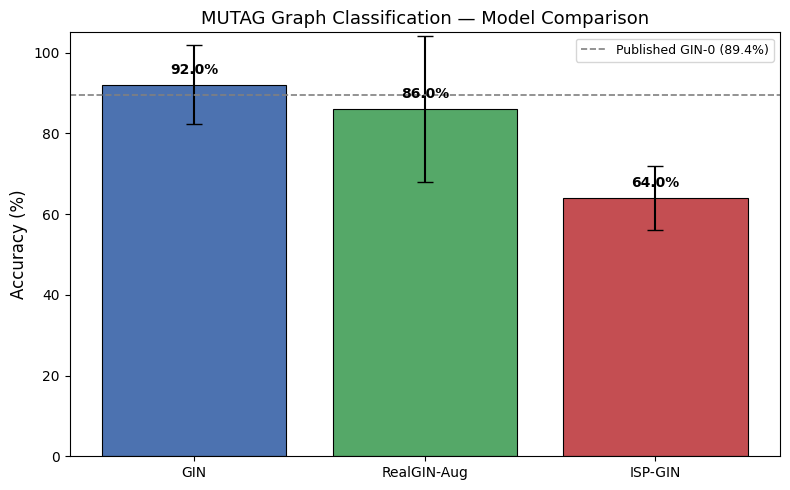

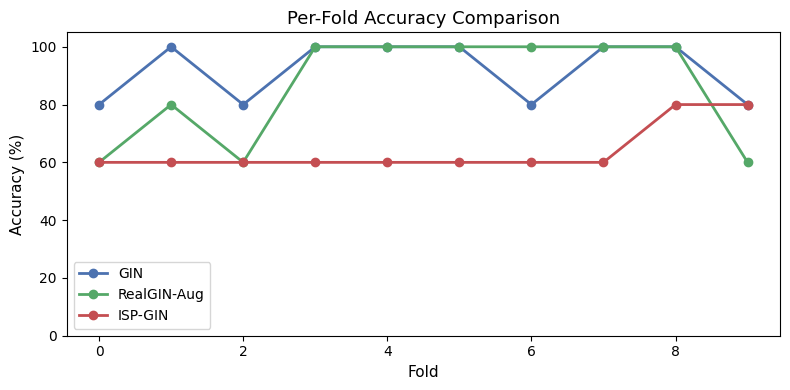

In [12]:
# ── Results Table ──
print("=" * 55)
print("RESULTS SUMMARY — MUTAG (accuracy %)")
print("=" * 55)
print(f"{'Method':<16} {'Mean':>8} {'Std':>8} {'Time(s)':>8}")
print("-" * 44)
for name, label in [("gin_baseline", "GIN"), ("realgin_aug", "RealGIN-Aug"), ("isp_gin", "ISP-GIN")]:
    r = all_results[name]
    print(f"{label:<16} {r['mean_acc']*100:7.1f}% {r['std_acc']*100:7.1f}% {r['total_time']:7.1f}")

# ── Published baselines from metadata ──
baselines = data["metadata"].get("baselines", {}).get("results", {}).get("MUTAG", {})
if baselines:
    print(f"\n{'Published Baselines (MUTAG)':}")
    print("-" * 44)
    for bname, bval in baselines.items():
        print(f"  {bname:<14} {bval['mean']:5.1f} ± {bval['std']:.1f}%")

# ── Bar Chart ──
fig, ax = plt.subplots(figsize=(8, 5))

methods = ["GIN", "RealGIN-Aug", "ISP-GIN"]
means = [all_results[k]["mean_acc"] * 100 for k in ["gin_baseline", "realgin_aug", "isp_gin"]]
stds = [all_results[k]["std_acc"] * 100 for k in ["gin_baseline", "realgin_aug", "isp_gin"]]

colors = ["#4C72B0", "#55A868", "#C44E52"]
bars = ax.bar(methods, means, yerr=stds, capsize=6, color=colors, edgecolor="black", linewidth=0.8)

# Add published GIN-0 reference line
if "GIN-0" in baselines:
    ax.axhline(y=baselines["GIN-0"]["mean"], color="gray", linestyle="--", linewidth=1.2, label=f"Published GIN-0 ({baselines['GIN-0']['mean']}%)")
    ax.legend(fontsize=9)

ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_title("MUTAG Graph Classification — Model Comparison", fontsize=13)
ax.set_ylim(0, 105)
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
            f"{mean:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

# ── Per-fold accuracy comparison ──
fig2, ax2 = plt.subplots(figsize=(8, 4))
for name, label, color in [("gin_baseline", "GIN", "#4C72B0"),
                            ("realgin_aug", "RealGIN-Aug", "#55A868"),
                            ("isp_gin", "ISP-GIN", "#C44E52")]:
    r = all_results[name]
    folds_used = sorted(set(g.fold for g in graphs))[:NUM_FOLDS]
    ax2.plot(folds_used, [a * 100 for a in r["fold_accuracies"]], "o-", label=label, color=color, linewidth=2)

ax2.set_xlabel("Fold", fontsize=11)
ax2.set_ylabel("Accuracy (%)", fontsize=11)
ax2.set_title("Per-Fold Accuracy Comparison", fontsize=13)
ax2.legend(fontsize=10)
ax2.set_ylim(0, 105)
plt.tight_layout()
plt.show()